In this notebook, we demonstrate how to train BBHnet on a small training dataset.

In [1]:
import os
import h5py
import copy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.facecolor']  = 'w'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Read in BBHnet dataset

First, we would like to download and load in the training and validation data. 

The data can be downloaded using the command below:

```
!wget https://www.dropbox.com/s/iwyxhumvp6bhb6x/data.tar.gz?dl=1 -O data.tar.gz \
    && tar -xf data.tar.gz && rm data.tar.gz
```

The example data will be in HDF5 format, which can be read using `h5py` package.
The fields in the HDF5 files are:

- `data`: 
The Hanford and Livingston strain with shape of `(N, 2, 1024)`, where `N` is the number of samples.
In the second dimension, the first channel is always Hanford, and the second channel is always Livingston.

- `corr`: 
The Pearson correlation array of each sample. Has a shape of `(N, 80)`.

- `label`: 
The label of each sample. Label `0` is for background noise, `1` is for BBH signal, and `2` is for glitches.

The example data is a subset of the full training dataset and has already gone through preprocessing.
It has the same data format that `train_bbhnet.py` takes in. 
**Note that the input data must already be preprocessed, 
since `train_bbhnet.py` does not apply any preprocessing to the data**.

In [2]:
# un-comment these two lines below to download data
# !wget https://www.dropbox.com/s/iwyxhumvp6bhb6x/data.tar.gz?dl=1 -O data.tar.gz \
#     && tar -xf data.tar.gz && rm data.tar.gz

In [3]:
# Read in training and validation data 
def read_data(input_file):
    ''' convenience function to read HDF5 data '''
    with h5py.File(input_file, 'r') as f:
        data = f['data'][:]
        corr = f['corr'][:]
        label = f['label'][:]
    return data, label, corr

train_data, train_label, train_corr = read_data('data/example_training_data.h5')
val_data, val_label, val_corr = read_data('data/example_validation_data.h5')

print('Train data shape: {}'.format(train_data.shape))
print('Train corr shape: {}'.format(train_corr.shape))
print('Train label shape: {}'.format(train_label.shape))
print('Val data shape: {}'.format(val_data.shape))
print('Val corr shape: {}'.format(val_corr.shape))
print('Val label shape: {}'.format(val_label.shape))

# Because glitches are labeled 2, we want to combine glitch and background as label 0
# also reshape true label from [N, 1] to [N, ] for convienience later
train_true_label = copy.deepcopy(train_label)
train_true_label = train_true_label.ravel()
train_label[train_label==2] = 0
val_true_label = copy.deepcopy(val_label)
val_true_label = val_true_label.ravel()
val_label[val_label==2] = 0

Train data shape: (5000, 2, 1024)
Train corr shape: (5000, 80)
Train label shape: (5000, 1)
Val data shape: (1000, 2, 1024)
Val corr shape: (1000, 80)
Val label shape: (1000, 1)


To verify that we read in the data correctly, we will plot the strain and the correlation array
for each label.

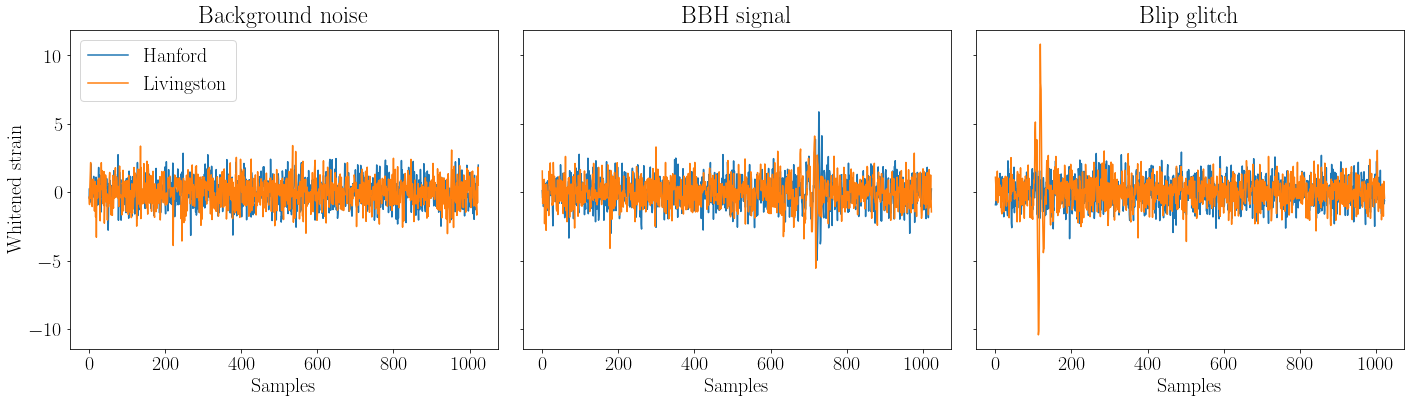

In [4]:
# Plotting the strain
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(20, 6), sharey='row')

# plot background
ax1.plot(train_data[1, 0], label='Hanford')
ax1.plot(train_data[1, 1], label='Livingston')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Whitened strain')
ax1.set_title('Background noise')
ax1.legend(loc=2)

# plot BBH
ax2.plot(train_data[5, 0], label='Hanford')
ax2.plot(train_data[5, 1], label='Livingston')
ax2.set_xlabel('Samples')
ax2.set_title('BBH signal')

# plot glitches
ax3.plot(train_data[0, 0], label='Hanford')
ax3.plot(train_data[0, 1], label='Livingston')
ax3.set_xlabel('Samples')
ax3.set_title('Blip glitch')

fig.tight_layout()

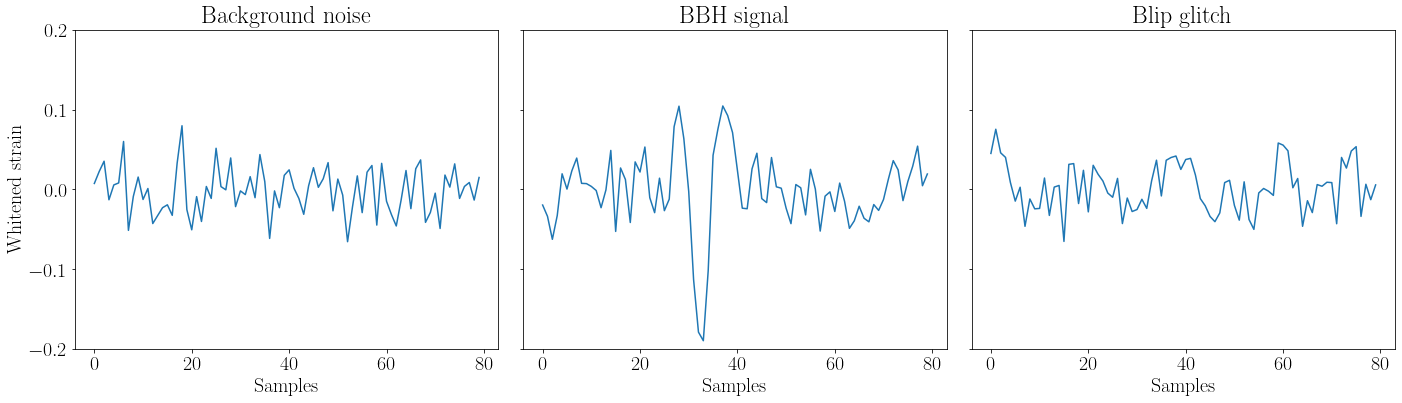

In [5]:
# Plotting the strain
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(20, 6), sharey='row')

# We will also plot the correlation array
ax1.plot(train_corr[1], label='Hanford')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Whitened strain')
ax1.set_title('Background noise')

# plot BBH
ax2.plot(train_corr[5], label='Hanford')
ax2.set_xlabel('Samples')
ax2.set_title('BBH signal')

# plot glitches
ax3.plot(train_corr[0], label='Hanford')
ax3.set_xlabel('Samples')
ax3.set_title('Blip glitch')
ax3.set_ylim(-0.2, 0.2)

fig.tight_layout()

In the signal case (`label==1`), we see a coherent sinusoidal rise in the strains of both Hanford and Livingston. 
This is even more apparent in the Pearson correlation array figure.
In the blip glitch case (`label==2`), the strain of one detector (in this case Livingston) rise, but the strain of the other detector (in this case Hanford) remains at background level.
The rise is not coherent, as apparent in the Pearson correlation array figure.

We verify that the dataset is read in and labeled correctly.
Now it's time to create and train a neural network model on this dataset.

# Training BBHnet

The BBHnet takes in the strains from Hanford and Livingston and the Pearson correlation array. 
The strains are put through some convolutional layers, while the correlation array is put through
some fully-connected (FC) layers.
The outputs from these layers are then concatenated, and then further put through some FC layers
to get a classification score.

The complete architecture for the BBHnet in this example is shown below:

<img src="bbhnet_arch.png" width=400 height=600 />

In [6]:
# Define convienient NN block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 3, padding=padding),
            nn.MaxPool1d(4, 4),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)
class FCBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, out_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(out_channels)
        )
    def forward(self, x):
        return self.fc(x)

# Define Classifier
class Classifier(nn.Module):
    def __init__(self, input_shape, corr_dim=0, padding=1):
        super().__init__()

        # nn architecture: CONV + FC -> FC
        # 1D CONV layer for time series data
        self.featurizer = nn.Sequential(
            ConvBlock(input_shape[0], 8, padding=padding),
            ConvBlock(8, 16, padding=padding),
            ConvBlock(16, 32, padding=padding)

        )
        # FC layer for Pearson correlation series
        fc_dim = self.get_flattened_size(input_shape)
        if corr_dim > 0:
            self.corr_featurizer = nn.Sequential(
                FCBlock(corr_dim, 32),
                FCBlock(32, 32),
            )
            fc_dim += 32

        # FC classifier combines features output
        self.classifier = nn.Sequential(
            FCBlock(fc_dim, 64),
            FCBlock(64, 32),
            nn.Linear(32, 1),
        )

    def forward(self, x, x_corr=None):
        x = self.featurizer(x)
        x = x.view(x.size(0), -1)
        if x_corr is not None:
            x_corr = self.corr_featurizer(x_corr)
            x = torch.cat([x, x_corr], axis=1)
        x = self.classifier(x)
        return x

    def get_flattened_size(self, input_shape):
        x = torch.rand(1, *input_shape)
        out = self.featurizer(x)
        out_dim = 1
        for i in range(len(out.shape)):
            out_dim *= out.shape[i]
        return out_dim

In [7]:
# set seed for reproducibility
torch.manual_seed(0)

# configure GPU/CPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create a small BBHnet model
net = Classifier((2, 1024), 80)
net.to(device)   # move BBHnet to GPU if needed

Classifier(
  (featurizer): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(2, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (corr_featurizer): Sequential(
    (0): FCBlock(
      (fc): Sequential(
        (0): Linear(in_features=80, out_features=32, bias=False)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.5, 

Once we have set up the neural network, we can then set up the loss function 
and the gradient descent (GD) optimizer.
For the loss function, we use `torch.nn.BCEWithLogitsLoss`.
For the GD optimizer, we use the ADAM optimizer with default learning rate of $10^{-3}$.

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [9]:
# For convienience, we use torch.utils.data.DataLoader to load data into batches
batch_size = 1000
train_loader = DataLoader(list(zip(train_data, train_label, train_corr)), 
                          batch_size=batch_size)
val_loader = DataLoader(list(zip(val_data, val_label, val_corr)), 
                        batch_size=batch_size)

In [10]:
# we train the BBHnet for 30 epochs
for ep in range(30):
    
    # Start training
    net.train()    # turn on training mode (affect batch norm, drop out, etc.)
    train_loss = 0;   # keep track of training loss
    for batch in train_loader:
        # Pytorch keeps track of the cumulative gradient
        # we need to reset the gradient every time we apply GD
        optimizer.zero_grad()
        
        # Type conversion and move batch to GPU if needed
        x = batch[0].float().to(device)
        y = batch[1].float().to(device)   # torch.nn.BCELoss takes in loss
        x_corr = batch[2].float().to(device)
        
        # Forward pass and calculate loss
        yhat = net(x, x_corr)
        loss = criterion(yhat, y)
        
        # Backward pass (calculate gradient) and apply GD
        loss.backward()
        optimizer.step()
        
        # keep track of train loss for book keeping
        train_loss += loss.item() * len(x)
    
    # Start validating
    net.eval()    # turn on evaluation mode (affect batch norm, drop out, etc.)
    val_loss = 0.
    
    # there is no gradient descent in the validation case
    # so we turn of gradient tracking to save time
    with torch.no_grad():
        for batch in val_loader:
            # Type conversion and move batch to GPU if needed
            x = batch[0].float().to(device)
            y = batch[1].float().to(device)   # torch.nn.BCELoss takes in loss
            x_corr = batch[2].float().to(device)
    
            # Forward pass and calculate loss
            yhat = net(x, x_corr)
            loss = criterion(yhat, y)
            
            # keep track of val loss for book keeping
            val_loss += loss.item() * len(x)
            
    # At the end of each epoch, print out training and validation loss
    # normalized loss by number of samples
    train_loss /= len(train_data)
    val_loss /= len(val_data)
    print('Epoch {:02d}: train {:.4f} | val {:.4f}'.format(ep, train_loss, val_loss))

Epoch 00: train 0.6998 | val 0.6761
Epoch 01: train 0.6532 | val 0.6612
Epoch 02: train 0.6202 | val 0.6507
Epoch 03: train 0.5934 | val 0.6415
Epoch 04: train 0.5597 | val 0.6303
Epoch 05: train 0.5245 | val 0.6154
Epoch 06: train 0.4926 | val 0.5967
Epoch 07: train 0.4639 | val 0.5703
Epoch 08: train 0.4373 | val 0.5300
Epoch 09: train 0.4089 | val 0.4638
Epoch 10: train 0.3783 | val 0.4136
Epoch 11: train 0.3655 | val 0.3816
Epoch 12: train 0.3444 | val 0.3285
Epoch 13: train 0.3107 | val 0.3007
Epoch 14: train 0.3021 | val 0.2718
Epoch 15: train 0.2700 | val 0.2368
Epoch 16: train 0.2468 | val 0.2237
Epoch 17: train 0.2268 | val 0.2047
Epoch 18: train 0.2040 | val 0.1885
Epoch 19: train 0.1827 | val 0.1880
Epoch 20: train 0.1706 | val 0.1768
Epoch 21: train 0.1624 | val 0.2426
Epoch 22: train 0.1644 | val 0.2300
Epoch 23: train 0.1656 | val 0.1840
Epoch 24: train 0.1540 | val 0.1628
Epoch 25: train 0.1418 | val 0.1773
Epoch 26: train 0.1467 | val 0.1586
Epoch 27: train 0.1367 | val

# Performance on validation dataset

Now that we have finished training the BBHnet, we would like to test its performance on the validation dataset. 

In [11]:
val_output = []
with torch.no_grad():
    for batch in val_loader:
        # Type conversion and move batch to GPU if needed
        x = batch[0].float().to(device)
        y = batch[1].float().to(device)   # torch.nn.BCELoss takes in loss
        x_corr = batch[2].float().to(device)

        # Forward pass and calculate loss
        yhat = net(x, x_corr)
        val_output.append(yhat.cpu().numpy())
val_output = np.concatenate(val_output)
val_output = val_output.ravel()   # change from [N, 1] to [N, ]

The BBHnet output `val_output` goes from $[-\infty, +\infty]$, with greater the score the more likely the input sample containing a BBH signal.
First, we would like to see the distribution of the BBHnet score for each label (with background noise and glitches as separate labels).

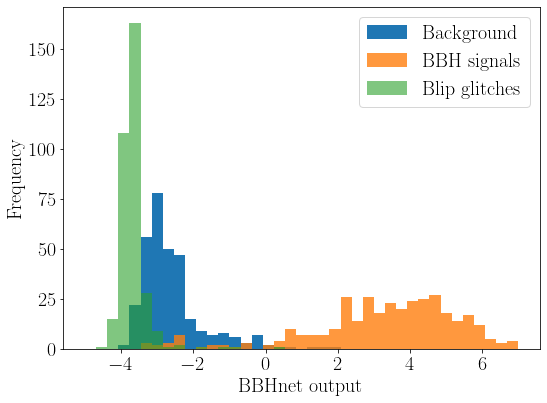

In [12]:
fig, ax = plt.subplots()

bins = np.linspace(-5, 7, 40)
ax.hist(val_output[val_true_label==0], bins, 
        label='Background')
ax.hist(val_output[val_true_label==1], bins, alpha=0.8,
        label='BBH signals')
ax.hist(val_output[val_true_label==2], bins, alpha=0.6,
        label='Blip glitches')
ax.set_xlabel('BBHnet output')
ax.set_ylabel('Frequency')
# ax.set_yscale('log')
ax.legend(loc=0)

fig.tight_layout()

We see that the score distribution for signal is well-separated 
from the distribution for background and noise.
Interestingly, even though background and glitches are trained under the same labels, 
they are also well-separated.

We can now compute the reciever operating characteristic (ROC) curve and its area under the curve.
The ROC curve computes the true positive probability (i.e. the sensitivity) 
as a function of the false postitive probability of the BBHnet. 

Let $x_i$ be each data sample and $F_w$ be the function learned by the BBHnet with weight $w$ 
(i.e. $F_w(x_i)$ is the score the BBHnet gives the sample $x_i$). 
The true positive probability and false positive probability are defined as:

$$
\begin{align}
\mathrm{TPR}(t) &= \frac{\sum_{i \in \mathrm{signal}} \mathbf{1}[F_w(x_i) > t]}{N_{\mathrm{signal}}} \\
\mathrm{FPR}(t) &= \frac{\sum_{j \in \mathrm{noise}} \mathbf{1}[F_w(x_j) > t]}{N_{\mathrm{noise}}}
\end{align}
$$

Here the indices $i, j$ denote if the sample contains a BBH signal or not, and $t$ is the threshold.
The function $\mathbf{1}$ returns 1 if the condition is true and 0 otherwise. 

The AUC is defined as the area under the TPR v. FPR curve.
The AUC goes from 0 to 1, with 1 being the optimal classifier.
On the TPR v. FPR plane, a diagnonal line from [0, 0] to [1, 1] represents a random classifier,
with an AUC of 0.5.

We calculate the ROC curve and its AUC using `sklearn.metrics`.

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

val_label = val_label.ravel()  # convert [N, 1] to [N, ] for convienience

# Compute ROC curve and AUC for all samples
fpr, tpr, _ = roc_curve(val_label, val_output)
auc = roc_auc_score(val_label, val_output)

# we also compute the ROC curve and AUC for the background v. signal case
mask = (val_true_label == 0) | (val_true_label == 1)
fpr_bg, tpr_bg, _ = roc_curve(val_label[mask], val_output[mask])
auc_bg = roc_auc_score(val_label[mask], val_output[mask])

# and glitch v. signal case
mask = (val_true_label == 2) | (val_true_label == 1)
fpr_glitch, tpr_glitch, _ = roc_curve(val_label[mask], val_output[mask])
auc_glitch = roc_auc_score(val_label[mask], val_output[mask])

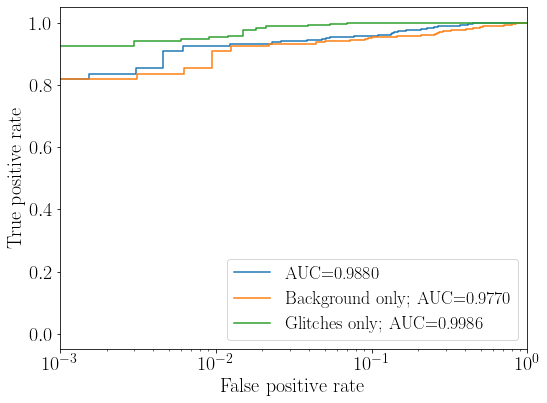

In [14]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr, label='AUC={:.4f}'.format(auc))
ax.plot(fpr_bg, tpr_bg, 
        label='Background only; AUC={:.4f}'.format(auc_bg))
ax.plot(fpr_glitch, tpr_glitch, 
        label='Glitches only; AUC={:.4f}'.format(auc_glitch))

ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_xscale('log')
ax.set_xlim(1e-3, 1)
ax.legend(loc=4, fontsize=18)

fig.tight_layout()

We see in all cases the AUC values are close to 1. 
This mini-BBHnet has done a decent job classifying between BBH signal v. background/glitches.
We see that there is a bit more discrimination power in the case of glitches v. BBH signals
than in the case of background v. BBH signals.
This could be due to low-SNR BBH signals that are difficult to be distinguished from
background noise.
Glitches, on the other hand, are loud in one detector (but not the other), and thus
easier for the BBHnet to distinguish.